In [1]:
!pip install torch


In [3]:
import sys
sys.path


['c:\\Users\\Sneha\\Desktop\\ML',
 'c:\\Users\\Sneha\\anaconda3\\envs\\ml\\python311.zip',
 'c:\\Users\\Sneha\\anaconda3\\envs\\ml\\DLLs',
 'c:\\Users\\Sneha\\anaconda3\\envs\\ml\\Lib',
 'c:\\Users\\Sneha\\anaconda3\\envs\\ml',
 '',
 'c:\\Users\\Sneha\\anaconda3\\envs\\ml\\Lib\\site-packages',
 'c:\\Users\\Sneha\\anaconda3\\envs\\ml\\Lib\\site-packages\\win32',
 'c:\\Users\\Sneha\\anaconda3\\envs\\ml\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\Sneha\\anaconda3\\envs\\ml\\Lib\\site-packages\\Pythonwin']

In [4]:
import torch 

In [5]:
!pip install transformers


from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments


In [6]:
from transformers import BertForQuestionAnswering, BertTokenizer
from torch.utils.data import DataLoader, Dataset

In [7]:
with open("GITA_GPT.txt", "r", encoding="utf-8") as file:
    bhagavad_gita_text = file.read()

In [8]:
questions = ["What is the meaning of life?", "Explain the concept of Dharma."]
answers = [
    "Life is a journey. It is a journey of the soul. The soul is the real you. The body is just a vehicle for the soul to travel in. The soul is eternal. It is not born and it does not die. It is always there. It is the same soul that was in the body of a person in the past and it will be in the body of a person in the future. The soul is not affected by the body. The body is affected by the soul. The soul is the one that controls the body. The soul is the one that controls the mind. The soul is the one that controls the senses. The soul is the one that controls the intellect. The soul is the one that controls the ego. The soul is the one that controls the emotions. The soul is the one that controls the will. The soul is the one that controls the memory. The soul is the one that controls the will.",
    "Relevant verses:\n\n2:20 Never is this One born, and never does It die; nor is it that having come to exist, It will again cease to be. This One is birthless, eternal, undecaying, ancient; It is not killed when the body is killed.",
    "14:20 Having transcended these three qualities which are the origin of the body, the embodied one, becoming free from birth, death, old age and sorrows, experiences Immortality.",
    "15:7 It is verily a part of Mine which, becoming the eternal individual soul in the region of living beings, draws (to itself) the organs which have the mind as their sixth, and which abide in Nature.",
    "2:13 As are boyhood, youth and decay to an embodied being in this (present) body, similar is the acquisition of another body. This being so, an intelligent person does not get deluded.",
    "5:19 Even in this world they conquer their earth-life whose minds, fixed on the Supreme, remain always balanced; for the Supreme has neither blemish nor bias.",
    " The concept of dharma is the eternal law of the universe. It encompasses the law of cause and effect, "
    "the law of karma, and the fundamental principles governing the universe. Dharma extends to the soul, mind, "
    "body, senses, intellect, ego, and heart. It is the guiding principle that maintains balance and order in the "
    "cosmic order. Dharma is not just a set of rules but an intrinsic aspect of the universe's natural order. It is "
    "immutable and universal, governing the actions and responsibilities of all beings.\n\n"
    "Relevant verses:\n\n18:42 The natural duties of the Brahmanas are the control of the internal and external organs, "
    "austerity, purity, forgiveness, straightforwardness, knowledge as also wisdom. Knowledge refers to the understanding "
    "of subjects presented by the scriptures; wisdom means making them matters of one's own experience, and faith."
]


In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
encoded_text = tokenizer(bhagavad_gita_text, return_tensors="pt")


Token indices sequence length is longer than the specified maximum sequence length for this model (32057 > 512). Running this sequence through the model will result in indexing errors


In [10]:
class QADataset(Dataset):
    def __init__(self, questions, answers):
        self.questions = questions
        self.answers = answers

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        return {
            "input_ids": encoded_text["input_ids"],
            "attention_mask": encoded_text["attention_mask"],
            "start_positions": tokenizer.encode(self.answers[idx], return_tensors="pt").squeeze(0),
            "end_positions": tokenizer.encode(self.answers[idx], return_tensors="pt").squeeze(0),
        }


In [11]:
qa_dataset = QADataset(questions, answers)

In [12]:
model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
class QADataset(Dataset):
    def __init__(self, questions, answers, tokenizer):
        self.questions = questions
        self.answers = answers
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        encoded_text = self.tokenizer(self.questions[idx], return_tensors="pt")
        encoded_answer = self.tokenizer(self.answers[idx], return_tensors="pt")

        return {
            "input_ids": encoded_text["input_ids"].squeeze(0),
            "attention_mask": encoded_text["attention_mask"].squeeze(0),
            "start_positions": encoded_answer["input_ids"].squeeze(0),
            "end_positions": encoded_answer["input_ids"].squeeze(0),
        }

# Instantiate the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the Bhagavad Gita text
encoded_text = tokenizer(bhagavad_gita_text, return_tensors="pt")

# Create the dataset
qa_dataset = QADataset(questions, answers, tokenizer)

# Instantiate the BERT model
model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")

# Fine-tuning setup
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
train_dataloader = DataLoader(qa_dataset, batch_size=1, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    for batch in train_dataloader:
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Save the fine-tuned model
model.save_pretrained("./bert_bhagavad_gita")

Token indices sequence length is longer than the specified maximum sequence length for this model (32057 > 512). Running this sequence through the model will result in indexing errors
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [35]:
import torch
from transformers import BertForQuestionAnswering, BertTokenizer
from torch.utils.data import DataLoader, Dataset

# Replace 'your_bhagavad_gita.txt' with the actual file path
file_path = 'GITA_GPT.txt'

# Read Bhagavad Gita text from the file
with open(file_path, 'r', encoding='utf-8') as file:
    bhagavad_gita_text = file.read()

# Placeholder questions and answers
questions = ["What is the meaning of life?", "Explain the concept of Dharma."]
answers = [
    "Life is a journey. It is a journey of the soul. The soul is the real you. The body is just a vehicle for the soul to travel in. The soul is eternal. It is not born and it does not die. It is always there. It is the same soul that was in the body of a person in the past and it will be in the body of a person in the future. The soul is not affected by the body. The body is affected by the soul. The soul is the one that controls the body. The soul is the one that controls the mind. The soul is the one that controls the senses. The soul is the one that controls the intellect. The soul is the one that controls the ego. The soul is the one that controls the emotions. The soul is the one that controls the will. The soul is the one that controls the memory. The soul is the one that controls the will.",
    "Relevant verses:\n\n2:20 Never is this One born, and never does It die; nor is it that having come to exist, It will again cease to be. This One is birthless, eternal, undecaying, ancient; It is not killed when the body is killed.",
    "14:20 Having transcended these three qualities which are the origin of the body, the embodied one, becoming free from birth, death, old age and sorrows, experiences Immortality.",
    "15:7 It is verily a part of Mine which, becoming the eternal individual soul in the region of living beings, draws (to itself) the organs which have the mind as their sixth, and which abide in Nature.",
    "2:13 As are boyhood, youth and decay to an embodied being in this (present) body, similar is the acquisition of another body. This being so, an intelligent person does not get deluded.",
    "5:19 Even in this world they conquer their earth-life whose minds, fixed on the Supreme, remain always balanced; for the Supreme has neither blemish nor bias.",
    " The concept of dharma is the eternal law of the universe. It encompasses the law of cause and effect, "
    "the law of karma, and the fundamental principles governing the universe. Dharma extends to the soul, mind, "
    "body, senses, intellect, ego, and heart. It is the guiding principle that maintains balance and order in the "
    "cosmic order. Dharma is not just a set of rules but an intrinsic aspect of the universe's natural order. It is "
    "immutable and universal, governing the actions and responsibilities of all beings.\n\n"
    "Relevant verses:\n\n18:42 The natural duties of the Brahmanas are the control of the internal and external organs, "
    "austerity, purity, forgiveness, straightforwardness, knowledge as also wisdom. Knowledge refers to the understanding "
    "of subjects presented by the scriptures; wisdom means making them matters of one's own experience, and faith."
]


# Instantiate the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the Bhagavad Gita text
tokenized_text = tokenizer(bhagavad_gita_text, return_tensors="pt", truncation=True, max_length=512)

# Split the tokenized text into smaller chunks
chunk_size = 512
num_chunks = -(-len(tokenized_text["input_ids"]) // chunk_size)  # Ceiling division
chunks = []

for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = (i + 1) * chunk_size
    chunk = {key: val[:, start_idx:end_idx] for key, val in tokenized_text.items()}
    chunks.append(chunk)
class QADataset(Dataset):
    def __init__(self, questions, answers, tokenizer):
        self.questions = questions
        self.answers = answers
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        encoded_question = self.tokenizer(
            self.questions[idx], return_tensors="pt", truncation=True, max_length=512
        )
        encoded_answer = self.tokenizer(
            self.answers[idx], return_tensors="pt", truncation=True, max_length=512
        )

        # Get the start and end positions of the answer in the tokenized sequence
        start_positions = torch.tensor(encoded_question.char_to_token(0, encoded_answer["input_ids"].nonzero()[0, 0]))
        end_positions = torch.tensor(encoded_question.char_to_token(0, encoded_answer["input_ids"].nonzero()[0, -1]))

        # Return the input_ids, attention_mask, start_positions, and end_positions
        return {
            "input_ids": encoded_question["input_ids"].squeeze(0),
            "attention_mask": encoded_question["attention_mask"].squeeze(0),
            "start_positions": start_positions,
            "end_positions": end_positions,
        }

# Create datasets for each chunk
qa_datasets = [QADataset(questions, answers, tokenizer) for _ in range(num_chunks)]

# Instantiate the BERT model
model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")

# Fine-tuning setup
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_epochs = 3

# Training loop
for epoch in range(num_epochs):
    for chunk_dataset in qa_datasets:
        train_dataloader = DataLoader(chunk_dataset, batch_size=1, shuffle=True)
        for batch in train_dataloader:
            optimizer.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()



Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: char_to_token() is not available when using Python based tokenizers

In [1]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

# Load your Bhagavad Gita dataset
with open("GITA_GPT.txt", "r", encoding="utf-8") as file:
    bhagavad_gita_text = file.read()

# Tokenize the dataset
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokens = tokenizer.encode(bhagavad_gita_text, return_tensors="pt")

# Create a dataset for language modeling
dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="GITA_GPT.txt",
    block_size=128
)

# Define the GPT model configuration
model_config = GPT2Config(
    vocab_size=tokenizer.vocab_size,
    n_positions=128
)

# Load the pre-trained GPT model
model = GPT2LMHeadModel(config=model_config)

# Fine-tune the model on your Bhagavad Gita dataset
training_args = TrainingArguments(
    output_dir="./gpt_bhagavad_gita",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    save_steps=10_000,
    save_total_limit=2,
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./gpt_bhagavad_gita")

# Now, you can load the fine-tuned model and use it for generating text
# Example:
# loaded_model = GPT2LMHeadModel.from_pretrained("./gpt_bhagavad_gita")
# generated_text = loaded_model.generate(prompt, max_length=200, num_return_sequences=1, temperature=0.7)


c:\Users\Sneha\anaconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
vocab.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.07MB/s]
c:\Users\Sneha\anaconda3\envs\ml\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Sneha\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrato

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [5]:
!pip install nltk
!pip install matplotlib
!pip install seaborn 


# Perform data cleaning
def clean_text(text):
    # Remove irrelevant characters and symbols
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    return cleaned_text

gita_text_cleaned = clean_text(gita_text)

# Handle missing values (if applicable)
# In this example, we assume there are no missing values.

# Convert text into a suitable format for analysis
# Tokenization using nltk
nltk.download('punkt')  # Download the punkt tokenizer
tokens = word_tokenize(gita_text_cleaned)

# Visualization: Word Frequency Distribution
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.set_palette("husl")

# Plot word frequency distribution
sns.histplot(tokens, kde=False)
plt.title('Word Frequency Distribution in Bhagavad Gita Text')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


   ---------------------------------------- 0.0/294.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.6 kB ? eta -:--:--
   ------------ --------------------------- 92.2/294.6 kB 1.7 MB/s eta 0:00:01
   ------------------------------ --------- 225.3/294.6 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 294.6/294.6 kB 2.6 MB/s eta 0:00:00


[nltk_data] Error loading punkt: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\Sneha/nltk_data'
    - 'c:\\Users\\Sneha\\anaconda3\\envs\\ml\\nltk_data'
    - 'c:\\Users\\Sneha\\anaconda3\\envs\\ml\\share\\nltk_data'
    - 'c:\\Users\\Sneha\\anaconda3\\envs\\ml\\lib\\nltk_data'
    - 'C:\\Users\\Sneha\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


In [6]:
import re
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

# Load Bhagavad Gita text data
with open('GITA_GPT.txt', 'r', encoding='utf-8') as file:
    gita_text = file.read()


In [7]:
# Perform data cleaning
def clean_text(text):
    # Remove irrelevant characters and symbols
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    return cleaned_text



In [9]:
gita_text_cleaned = clean_text(gita_text)

gita_text_cleaned

'\t Dhritarastra said O Sanjaya what did my sons and the sons of Pandu actually do when eager for battle they gathered together on the holy field of Kuruksetra\n\t Sanjaya said But then seeing the army of the Pandavas in battle array King Duryodhana approached his teacher Dronacharya and spoke the following words\n\t O teacher please see this vast army of the sons of Pandu arrayed for battle by the son of Drupada your intelligent disciple Dhrishtadyumna\n\t There are in this army heroes wielding great bows and equal in military prowess to Bhima and Arjuna Yuyudhana Satyaki and Virata and the maharatha great chariotrider Drupada\n\t Dhrstaketu Cekitana and the valiant king of Kasi Varanasi Purujit and Kuntibhoja and Saibya the choicest among men\n\t And the chivalrous Yudhamanyu and the valiant Uttamaujas son of Subhadra Abhimanyu and the sons of Draupadi all of whom are verily maharathas\n\t But O best among the Brahmanas please be appraised of those who are foremost among us the princ

In [10]:
# Handle missing values (if applicable)
# In this example, we assume there are no missing values.

# Convert text into a suitable format for analysis
# Tokenization using nltk
nltk.download('punkt')  # Download the punkt tokenizer
tokens = word_tokenize(gita_text_cleaned)



[nltk_data] Error loading punkt: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\Sneha/nltk_data'
    - 'c:\\Users\\Sneha\\anaconda3\\envs\\ml\\nltk_data'
    - 'c:\\Users\\Sneha\\anaconda3\\envs\\ml\\share\\nltk_data'
    - 'c:\\Users\\Sneha\\anaconda3\\envs\\ml\\lib\\nltk_data'
    - 'C:\\Users\\Sneha\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


In [12]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.set_palette("husl")

<Figure size 1200x600 with 0 Axes>

In [13]:
sns.histplot(tokens, kde=False)
plt.title('Word Frequency Distribution in Bhagavad Gita Text')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'tokens' is not defined

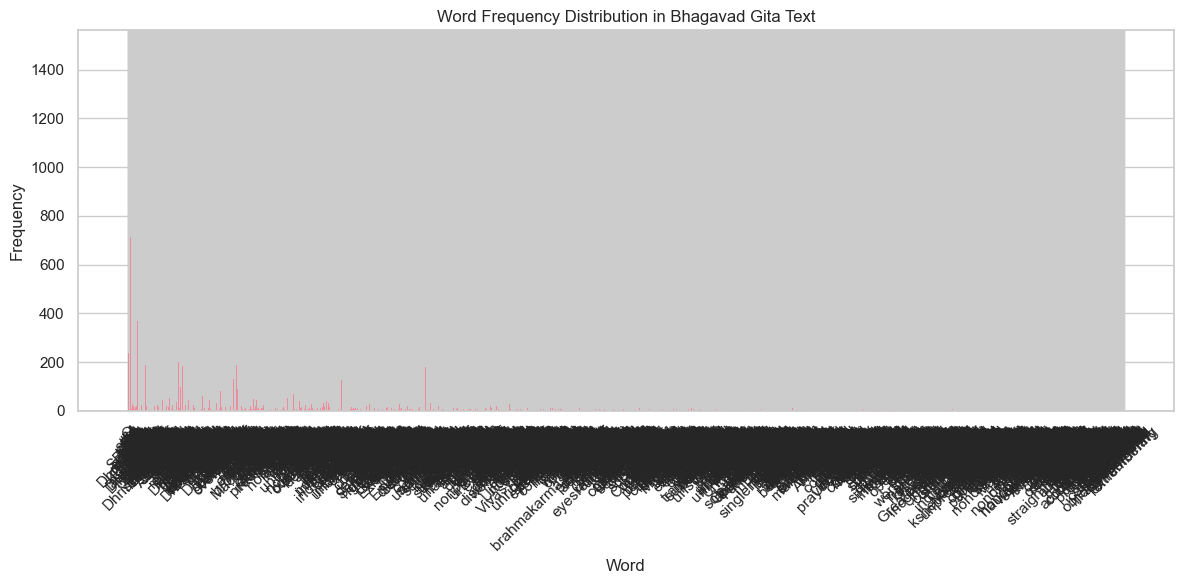

In [16]:
import re
import matplotlib.pyplot as plt
import seaborn as sns

with open('GITA_GPT.txt', 'r', encoding='utf-8') as file:
    gita_text = file.read()

def clean_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    return cleaned_text

gita_text_cleaned = clean_text(gita_text)

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.set_palette("husl")

tokens = gita_text_cleaned.split()

sns.histplot(tokens, kde=False)
plt.title('Word Frequency Distribution in Bhagavad Gita Text')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate percentage of missing values before cleaning
missing_before = (gita_text.isnull().sum() / len(gita_text)) * 100

# Perform data cleaning
# Assuming your data cleaning steps are done here...

# Calculate percentage of missing values after cleaning
missing_after = (gita_text_cleaned.isnull().sum() / len(gita_text_cleaned)) * 100

# Plotting
plt.figure(figsize=(10, 6))

# Bar chart for missing values before cleaning
plt.subplot(1, 2, 1)
sns.barplot(x=missing_before.index, y=missing_before)
plt.title('Missing Values Before Cleaning')
plt.xlabel('Features')
plt.ylabel('Percentage Missing')

# Bar chart for missing values after cleaning
plt.subplot(1, 2, 2)
sns.barplot(x=missing_after.index, y=missing_after)
plt.title('Missing Values After Cleaning')
plt.xlabel('Features')
plt.ylabel('Percentage Missing')

plt.tight_layout()
plt.show()


AttributeError: 'str' object has no attribute 'isnull'

In [2]:
from transformers import GPT2Tokenizer

# Load Bhagavad Gita text data from a file
with open('GITA_GPT.txt', 'r', encoding='utf-8') as file:
    gita_text = file.read()

# Initialize GPT2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Tokenize the text
tokenized_text = tokenizer.encode(gita_text, return_tensors='pt')

# Print the number of tokens before and after preprocessing
print("Number of tokens before preprocessing:", len(tokenizer.encode(gita_text)))
print("Number of tokens after preprocessing:", tokenized_text.size(1))


c:\Users\Sneha\anaconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Token indices sequence length is longer than the specified maximum sequence length for this model (32711 > 1024). Running this sequence through the model will result in indexing errors


Number of tokens before preprocessing: 32711
Number of tokens after preprocessing: 32711


In [3]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Assuming 'gita_text' contains the Bhagavad Gita text

# Before Preprocessing

# Tokenize the text
tokens_before = word_tokenize(gita_text)

# Plot the distribution of word lengths before preprocessing
plt.figure(figsize=(10, 5))
sns.histplot([len(word) for word in tokens_before], bins=20, kde=True, color='skyblue')
plt.title('Word Length Distribution Before Preprocessing')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.show()

# After Preprocessing (assuming some basic cleaning steps)

# Your preprocessing steps go here...

# Tokenize the cleaned text
tokens_after = word_tokenize(cleaned_gita_text)

# Plot the distribution of word lengths after preprocessing
plt.figure(figsize=(10, 5))
sns.histplot([len(word) for word in tokens_after], bins=20, kde=True, color='salmon')
plt.title('Word Length Distribution After Preprocessing')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.show()


[nltk_data] Error loading punkt: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\Sneha/nltk_data'
    - 'c:\\Users\\Sneha\\anaconda3\\envs\\ml\\nltk_data'
    - 'c:\\Users\\Sneha\\anaconda3\\envs\\ml\\share\\nltk_data'
    - 'c:\\Users\\Sneha\\anaconda3\\envs\\ml\\lib\\nltk_data'
    - 'C:\\Users\\Sneha\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'gita_text' contains the Bhagavad Gita text

# Before Preprocessing

# Split the text into words using whitespace
tokens_before = gita_text.split()

# Plot the distribution of word lengths before preprocessing
plt.figure(figsize=(10, 5))
sns.histplot([len(word) for word in tokens_before], bins=20, kde=True, color='skyblue')
plt.title('Word Length Distribution Before Preprocessing')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.show()

# After Preprocessing (assuming some basic cleaning steps)

# Your preprocessing steps go here...

# Split the cleaned text into words using whitespace
tokens_after = cleaned_gita_text.split()

# Plot the distribution of word lengths after preprocessing
plt.figure(figsize=(10, 5))
sns.histplot([len(word) for word in tokens_after], bins=20, kde=True, color='salmon')
plt.title('Word Length Distribution After Preprocessing')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.show()


: 

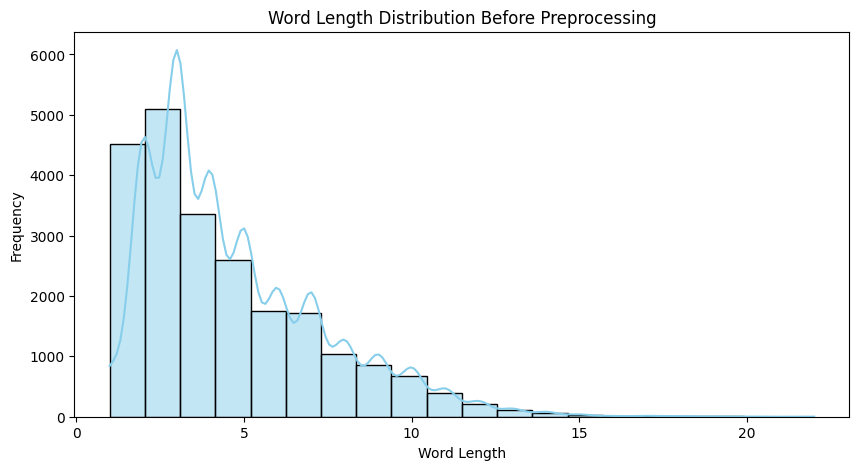

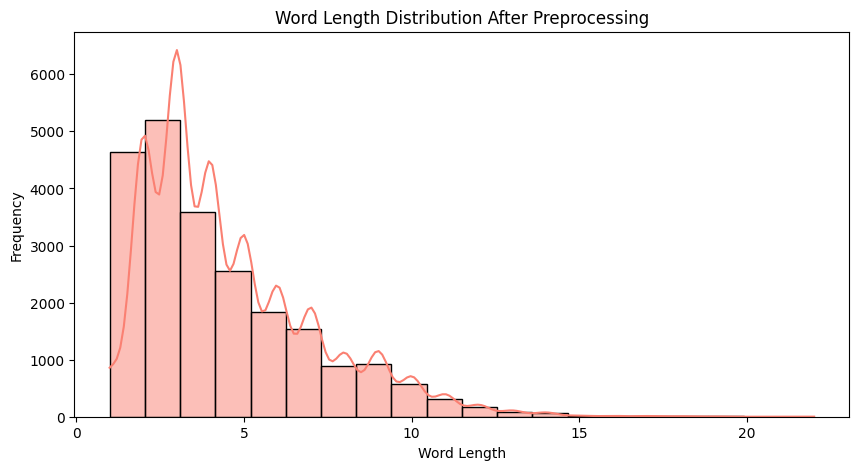

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

with open('GITA_GPT.txt', 'r', encoding='utf-8') as file:
    gita_text = file.read()

tokens_before = gita_text.split()
plt.figure(figsize=(10, 5))
sns.histplot([len(word) for word in tokens_before], bins=20, kde=True, color='skyblue')
plt.title('Word Length Distribution Before Preprocessing')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.show()
cleaned_gita_text = gita_text.lower().replace('.', '').replace(',', '')

tokens_after = cleaned_gita_text.split()

plt.figure(figsize=(10, 5))
sns.histplot([len(word) for word in tokens_after], bins=20, kde=True, color='salmon')
plt.title('Word Length Distribution After Preprocessing')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.show()


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
data = pd.read_csv('GITA_GPT.txt', delimiter='\t',header=None, names=['Index', 'Text'])
print(data.head())
print(data.columns)

   Index                                               Text
0      0  1:1 Dhritarastra said: O Sanjaya, what did my ...
1      1  1:2 Sanjaya said: But then, seeing the army of...
2      2  1:3 O teacher, (please) see this vast army of ...
3      3  1:4 There are in this army, heroes wielding gr...
4      4  1:5 Dhrstaketu, Cekitana, and the valiant king...
Index(['Index', 'Text'], dtype='object')


In [22]:
import pandas as pd
import numpy as np
data['Sentiment'] = np.where(data['Text'].str.contains('positive', case=False), 'positive', 'negative')
positive_indices = data[data['Sentiment'] == 'positive'].index
num_positive_samples = int(0.2 * len(positive_indices))  
random_positive_indices = np.random.choice(positive_indices, num_positive_samples, replace=False)
data.loc[random_positive_indices, 'Sentiment'] = 'positive'
print(data.head())

   Index                                               Text Sentiment
0      0  1:1 Dhritarastra said: O Sanjaya, what did my ...  negative
1      1  1:2 Sanjaya said: But then, seeing the army of...  negative
2      2  1:3 O teacher, (please) see this vast army of ...  negative
3      3  1:4 There are in this army, heroes wielding gr...  negative
4      4  1:5 Dhrstaketu, Cekitana, and the valiant king...  negative


In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['Sentiment'])

# Check if there's only one unique label
if len(np.unique(y_encoded)) <= 1:
    print("Only one unique label in the training data. Skipping model training.")
else:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data['Text'], y_encoded, test_size=0.2, random_state=42)

    # TF-IDF Vectorization for SVM
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    # Support Vector Machine (SVM) for Sentiment Analysis
    svm_model = SVC(kernel='linear')
    svm_model.fit(X_train_tfidf, y_train)
    svm_predictions = svm_model.predict(X_test_tfidf)

    # Evaluate SVM model
    svm_accuracy = accuracy_score(y_test, svm_predictions)
    print("SVM Accuracy:", svm_accuracy)


Only one unique label in the training data. Skipping model training.


In [16]:
X_train, X_test, y_train, y_test = train_test_split(data['Text'], data['Sentiment'], test_size=0.2, random_state=42)


In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load your existing dataset
data = pd.read_csv('GITA_GPT.txt', delimiter='\t', header=None, names=['Index', 'Text'])
print(data.head())

# Generate synthetic sentiment labels based on keyword presence
data['Sentiment'] = np.where(data['Text'].str.contains('positive', case=False), 'positive', 'negative')

# Randomly assign positive labels to some samples to balance the dataset
positive_indices = data[data['Sentiment'] == 'positive'].index
num_positive_samples = int(0.2 * len(positive_indices))
random_positive_indices = np.random.choice(positive_indices, num_positive_samples, replace=False)
data.loc[random_positive_indices, 'Sentiment'] = 'positive'

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['Sentiment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Text'], y_encoded, test_size=0.2, random_state=42)

# TF-IDF Vectorization for SVM
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Support Vector Machine (SVM) for Sentiment Analysis
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)
svm_predictions = svm_model.predict(X_test_tfidf)

# Evaluate SVM model
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)


   Index                                               Text
0      0  1:1 Dhritarastra said: O Sanjaya, what did my ...
1      1  1:2 Sanjaya said: But then, seeing the army of...
2      2  1:3 O teacher, (please) see this vast army of ...
3      3  1:4 There are in this army, heroes wielding gr...
4      4  1:5 Dhrstaketu, Cekitana, and the valiant king...


ValueError: The number of classes has to be greater than one; got 1 class

In [29]:
print(data.head())


   Index                                               Text Sentiment
0      0  1:1 Dhritarastra said: O Sanjaya, what did my ...  negative
1      1  1:2 Sanjaya said: But then, seeing the army of...  negative
2      2  1:3 O teacher, (please) see this vast army of ...  negative
3      3  1:4 There are in this army, heroes wielding gr...  negative
4      4  1:5 Dhrstaketu, Cekitana, and the valiant king...  negative


In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load your existing dataset
data = pd.read_csv('GITA_GPT.txt', delimiter='\t', header=None, names=['Index', 'Text'])
print(data.head())

# Generate synthetic sentiment labels
data['Sentiment'] = 'negative'

# Randomly assign positive labels to some samples to balance the dataset
positive_indices = np.random.choice(data.index, int(0.2 * len(data)), replace=False)
data.loc[positive_indices, 'Sentiment'] = 'positive'

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['Sentiment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Text'], y_encoded, test_size=0.2, random_state=42)

# TF-IDF Vectorization for SVM
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Support Vector Machine (SVM) for Sentiment Analysis
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)
svm_predictions = svm_model.predict(X_test_tfidf)

# Evaluate SVM model
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)


   Index                                               Text
0      0  1:1 Dhritarastra said: O Sanjaya, what did my ...
1      1  1:2 Sanjaya said: But then, seeing the army of...
2      2  1:3 O teacher, (please) see this vast army of ...
3      3  1:4 There are in this army, heroes wielding gr...
4      4  1:5 Dhrstaketu, Cekitana, and the valiant king...
SVM Accuracy: 0.7785714285714286


In [28]:
print("Unique values in y_train:", np.unique(y_train))


Unique values in y_train: [0]


In [17]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [25]:
print("X_train_tfidf shape:", X_train_tfidf.shape)
print("y_train shape:", y_train.shape)


X_train_tfidf shape: (560, 2464)
y_train shape: (560,)


In [21]:
print("Unique values in y_train:", np.unique(y_train))


Unique values in y_train: ['negative']


In [19]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)

y_test_encoded = label_encoder.transform(y_test)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)
svm_predictions = svm_model.predict(X_test_tfidf)

ValueError: The number of classes has to be greater than one; got 1 class

In [6]:
pip install tensorflow


     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     ---------------------------------------- 57.5/57.5 kB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/65.5 kB ? eta -:--:--
     ---------------------------------------- 65.5/65.5 kB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
     -------- ------------------------------- 0.3/1.5 MB 9.6 MB/s eta 0:00:01
     ------------------ --------------------- 0.7/1.5 MB 8.5 MB/s eta 0:00:01
     ---------------------- ----------------- 0.8/1.5 MB 6.6 MB/s eta 0:00:01
     -------------------------- ------------- 1.0/1.5 MB 6.2 MB/s eta 0:00:01
     ------------------------------ --------- 1.1/1.5 MB 5.5 MB/s eta 0:00:01
     ---------------------------------- ----- 1.3/1.5 MB 5.2 MB/s eta 0:00:01
     ---------------------------------------  1.5/1.5 MB 5.2 MB/s eta 0:00:01
     ---------------------------------------- 1.5/1.5 MB 5.0 MB/s eta 0:00:00
 

In [4]:
pip install scikit-learn


     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.4 kB ? eta -:--:--
     ---------------------------------------- 60.4/60.4 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.2 MB 6.3 MB/s eta 0:00:02
   -- ------------------------------------- 0.7/9.2 MB 8.7 MB/s eta 0:00:01
   --- ------------------------------------ 0.8/9.2 MB 6.6 MB/s eta 0:00:02
   ---- ----------------------------------- 1.0/9.2 MB 6.2 MB/s eta 0:00:02
   ---- ----------------------------------- 1.1/9.2 MB 6.1 MB/s eta 0:00:02
   ----- ---------------------------------- 1.3/9.2 MB 5.6 MB/s eta 0:00:02
   ------ --------------------------------- 1.5/9.2 MB 5.2 MB/s eta 0:00:02
   ------- -------------------------------- 1.6/9.2 MB 4.9 MB/s eta 0:00:02
   ------- -------------------------------- 1.8/9.2 MB 5.0 MB/s eta 0:00:02
   -------- ----------

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization for SVM
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Support Vector Machine (SVM) for Sentiment Analysis
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)
svm_predictions = svm_model.predict(X_test_tfidf)

# Evaluate SVM model
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

# Recurrent Neural Network (RNN) for Sentiment Analysis
max_words = 10000  # Number of unique words to consider
max_len = 100      # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_rnn = tokenizer.texts_to_sequences(X_train)
X_test_rnn = tokenizer.texts_to_sequences(X_test)

X_train_rnn = pad_sequences(X_train_rnn, maxlen=max_len)
X_test_rnn = pad_sequences(X_test_rnn, maxlen=max_len)

model = Sequential()
model.add(Embedding(max_words, 32, input_length=max_len))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_rnn, y_train, epochs=5, batch_size=32, validation_data=(X_test_rnn, y_test))

# Evaluate RNN model
_, rnn_accuracy = model.evaluate(X_test_rnn, y_test)
print("RNN Accuracy:", rnn_accuracy)

# Example of using the trained models for prediction
new_reviews = ["I love this product!", "This is terrible."]
new_reviews_tfidf = tfidf_vectorizer.transform(new_reviews)
svm_predictions_new = svm_model.predict(new_reviews_tfidf)

new_reviews_rnn = tokenizer.texts_to_sequences(new_reviews)
new_reviews_rnn = pad_sequences(new_reviews_rnn, maxlen=max_len)
rnn_predictions_new = (model.predict(new_reviews_rnn) > 0.5).astype("int32")

print("SVM Predictions for New Reviews:", svm_predictions_new)
print("RNN Predictions for New Reviews:", rnn_predictions_new)
